In [15]:
from sklearn import datasets, tree, metrics
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split

time_multiplicator = 1



In [16]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te):
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, alpha=0.5)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, alpha=0.2)
    
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0])

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1])
    my_disp.ax_.set_ylabel('')
    
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.predict(test_X))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(test_X))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    print('              | Sklearn | Własna')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, test_Y):9.4f}|{metrics.accuracy_score(my_pred, test_Y):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')

In [17]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value


class myTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, X, Y, curr_depth=0):
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples and curr_depth<=self.max_depth:
            best_split = self.get_best_split(X, Y, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["X_left"],best_split["Y_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["X_right"],best_split["Y_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, X, Y, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, Y_left, X_right, Y_right = self.split(X, Y, feature_index, threshold)
                if len(X_left)>0 and len(X_right)>0:
                    curr_info_gain = self.information_gain(Y, Y_left, Y_right)
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["X_right"] = X_right
                        best_split["Y_left"] = Y_left
                        best_split["Y_right"] = Y_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, X, Y, feature_index, threshold):
        X_left = []
        Y_left = []
        X_right = []
        Y_right = []
        for i, row in enumerate(X):
            if row[feature_index] <= threshold:
                X_left.append(row)
                Y_left.append(Y[i])
            else:
                X_right.append(row)
                Y_right.append(Y[i])
        
        return  np.array(X_left), np.array(Y_left), np.array(X_right), np.array(Y_right)
    
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy    
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        self.root = self.build_tree(X,Y)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

              | Sklearn | Własna
Czułość       |   1.0000|1.0000
Specyficzność |   0.4773|0.4784
Skuteczność   |   1.0000|0.9977
Czas wykonania| 8.39E-04|4.70E+00


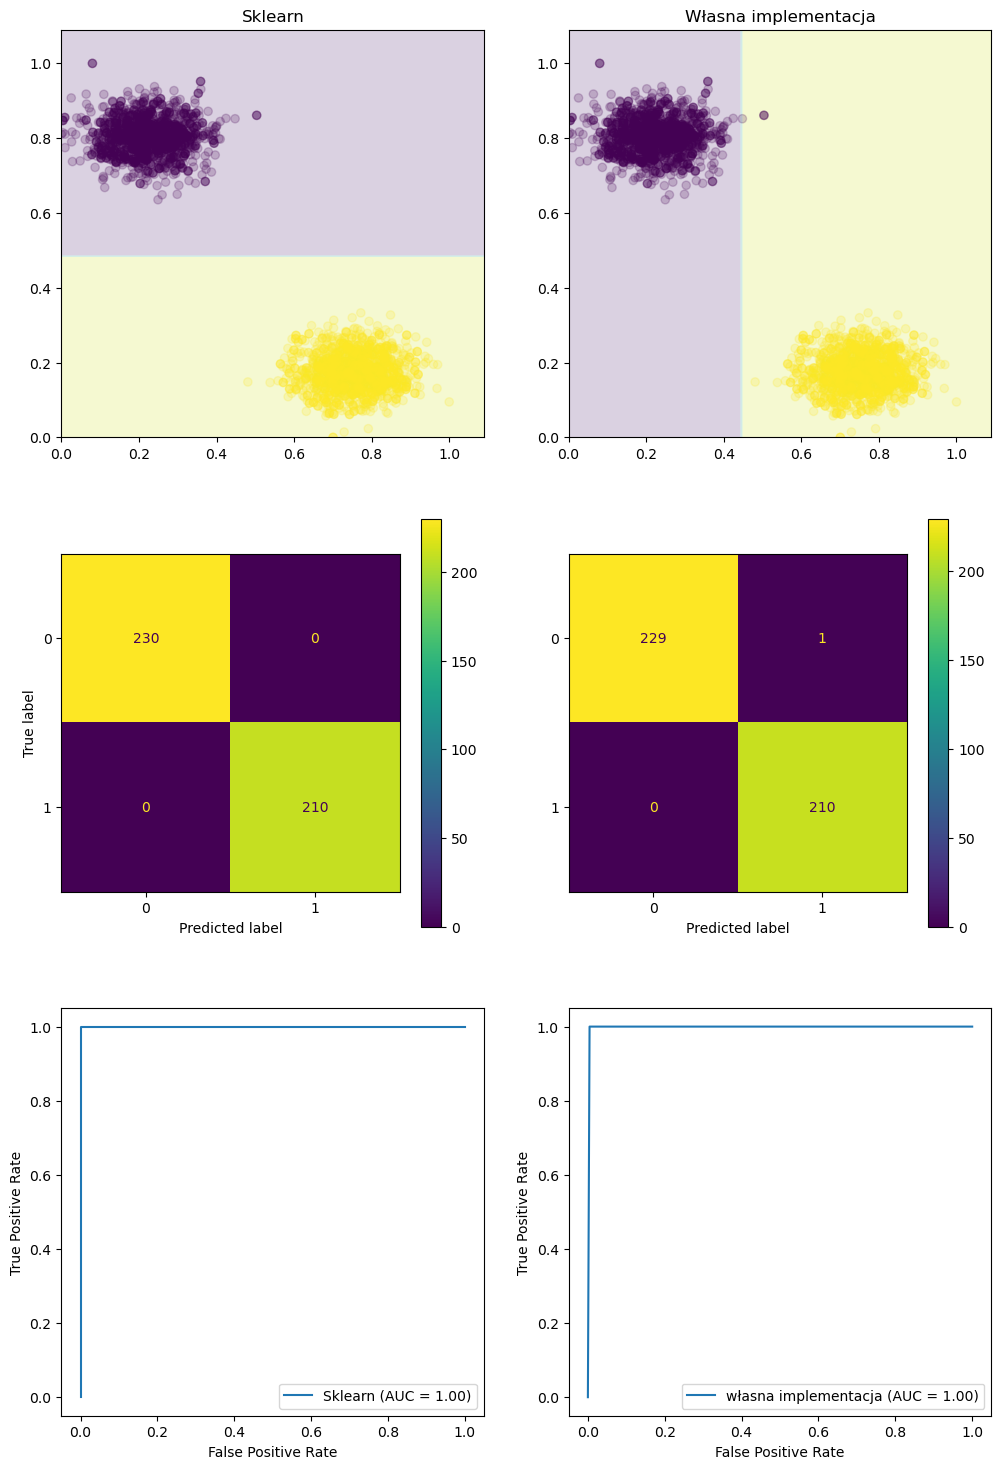

In [18]:
# 1 klaster na klasę

X, Y = datasets.make_blobs(n_samples=2200, n_features=2, random_state=222720, centers=2)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
train_X , test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=222720)

my_decision = myTree(min_samples_split=3, max_depth=5000)
sk_decision = tree.DecisionTreeClassifier()

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   0.9855|0.9812
Specyficzność |   0.5211|0.5140
Skuteczność   |   0.9682|0.9773
Czas wykonania| 3.25E-03|1.01E+01


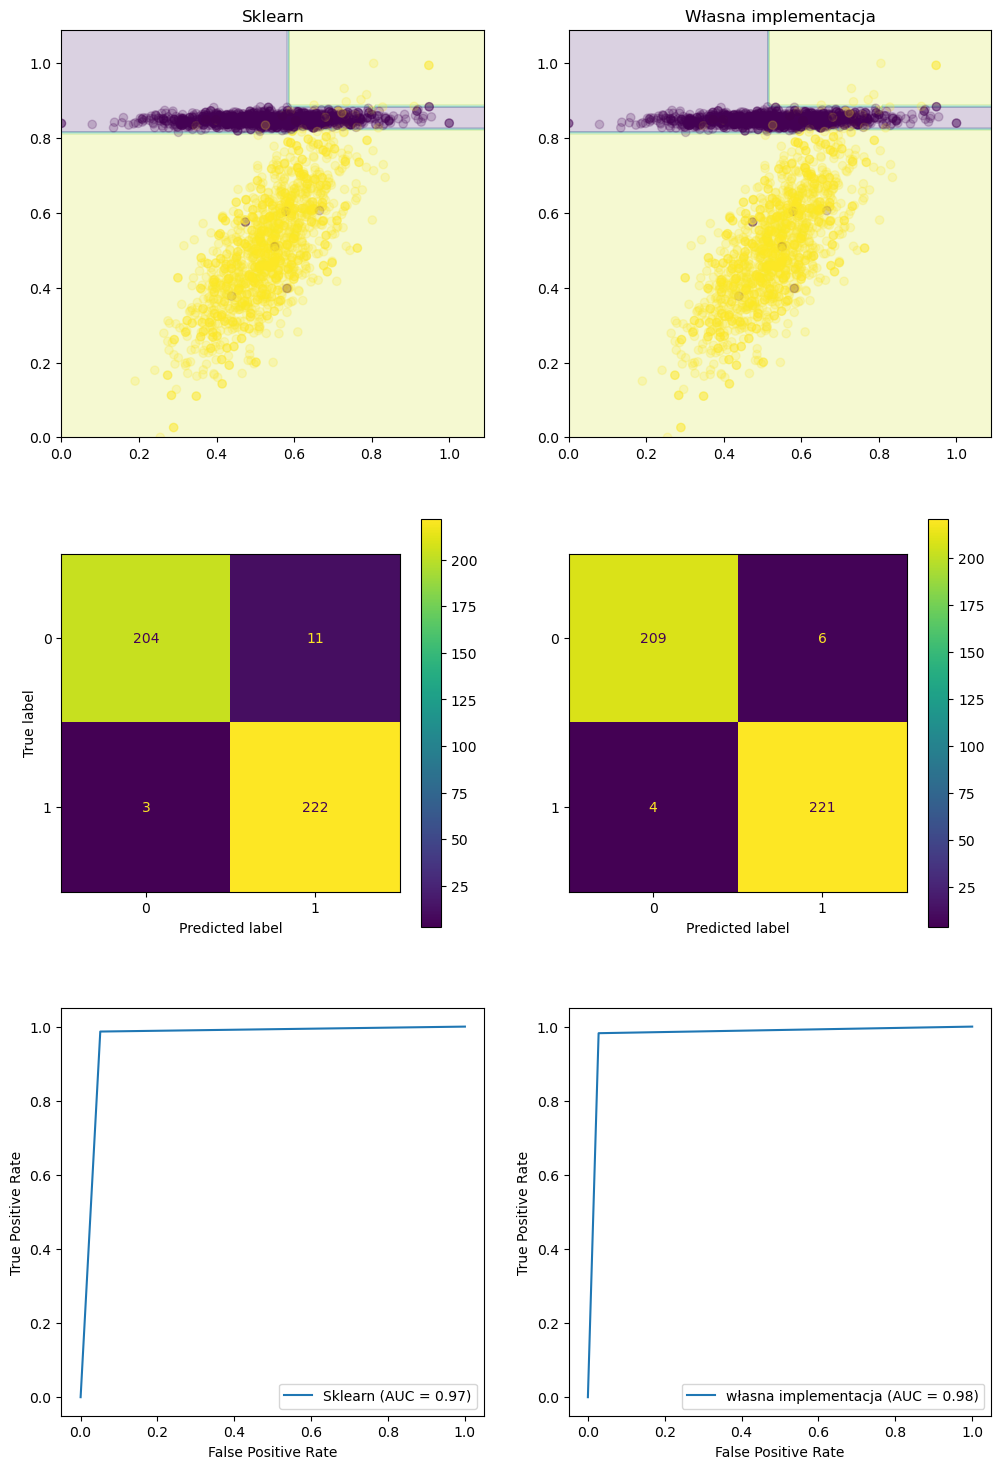

In [19]:
X, Y = datasets.make_classification(n_samples=2200, n_features=2, random_state=222720, n_redundant=0, n_classes=2, n_clusters_per_class=1, n_informative=2)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
train_X , test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=222720)

my_decision = myTree(min_samples_split=3, max_depth=5000)
sk_decision = tree.DecisionTreeClassifier()

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   0.9860|0.9860
Specyficzność |   0.5115|0.5115
Skuteczność   |   0.9864|0.9864
Czas wykonania| 1.22E-03|6.38E+00


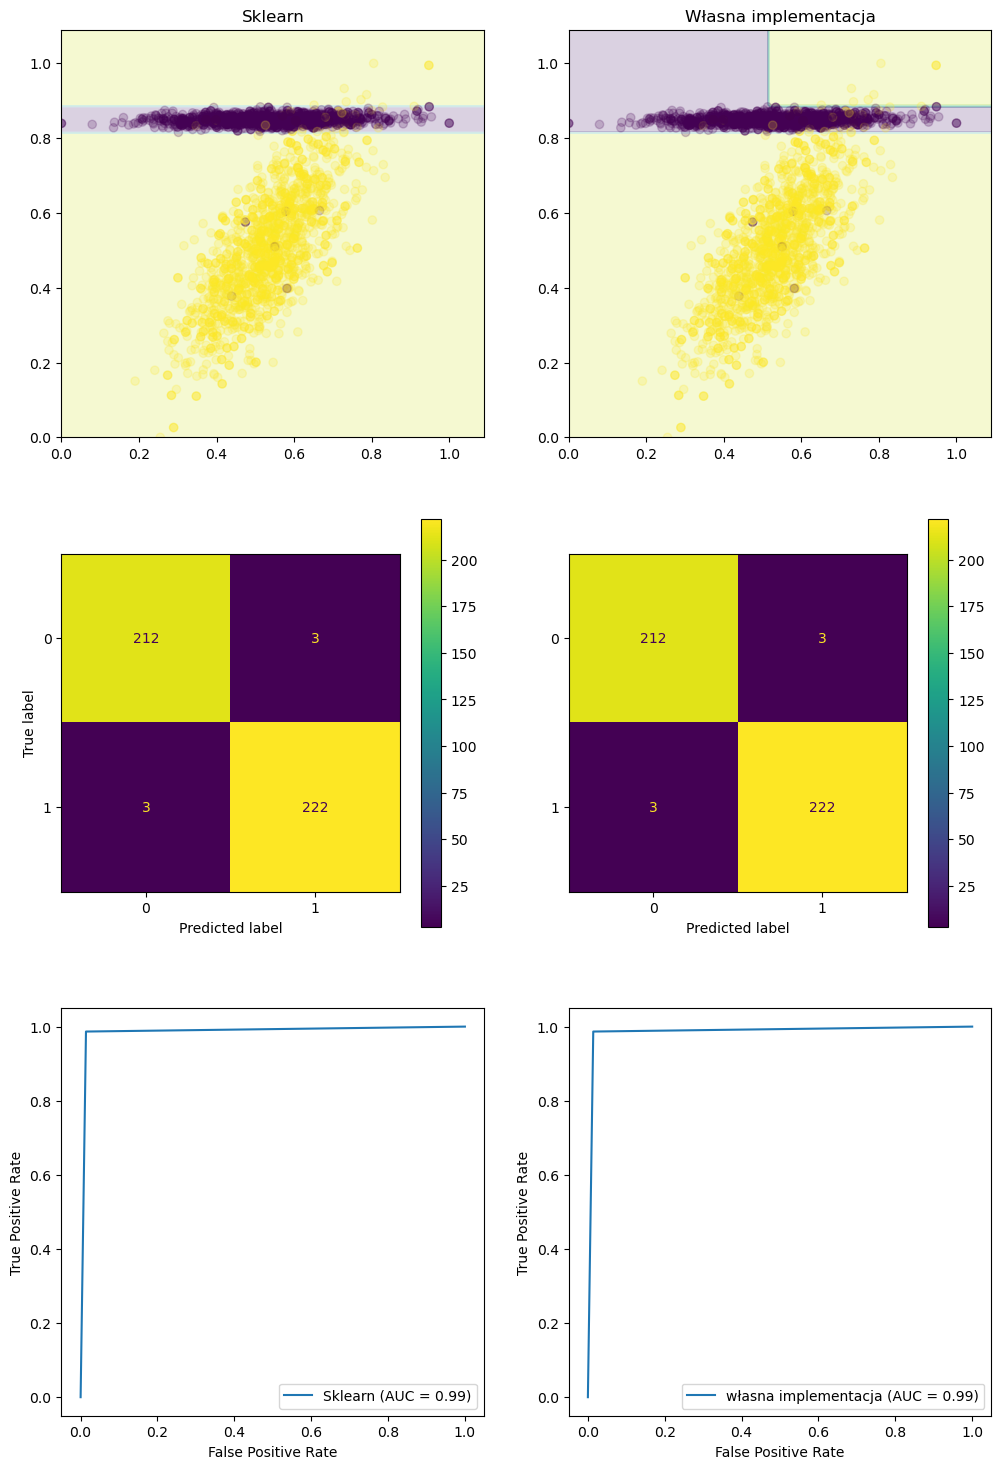

In [20]:
### Liczba cech == głębokości drzewa

my_decision = myTree(min_samples_split=3, max_depth=2)
sk_decision = tree.DecisionTreeClassifier(max_depth=2)

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   0.9816|0.9860
Specyficzność |   0.5092|0.5115
Skuteczność   |   0.9864|0.9864
Czas wykonania| 7.64E-04|4.70E+00


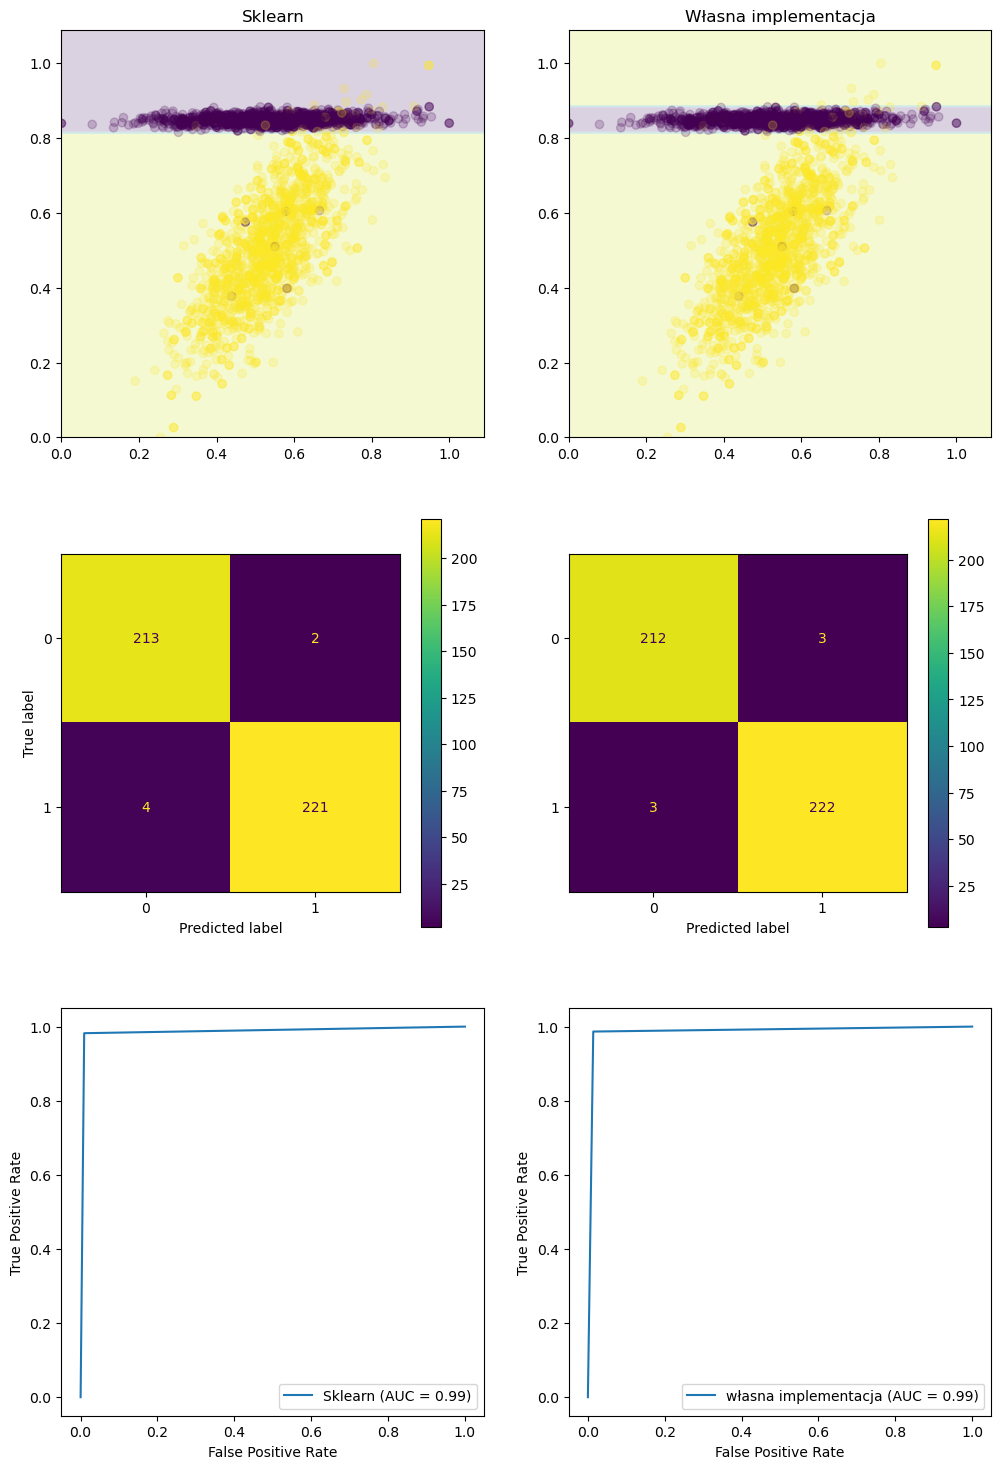

In [21]:
# Głębokość równa liczbie klastrów

my_decision = myTree(min_samples_split=3, max_depth=1)
sk_decision = tree.DecisionTreeClassifier(max_depth=1)

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   0.9823|0.9866
Specyficzność |   0.4861|0.4884
Skuteczność   |   0.9818|0.9818
Czas wykonania| 1.19E-03|6.78E+00


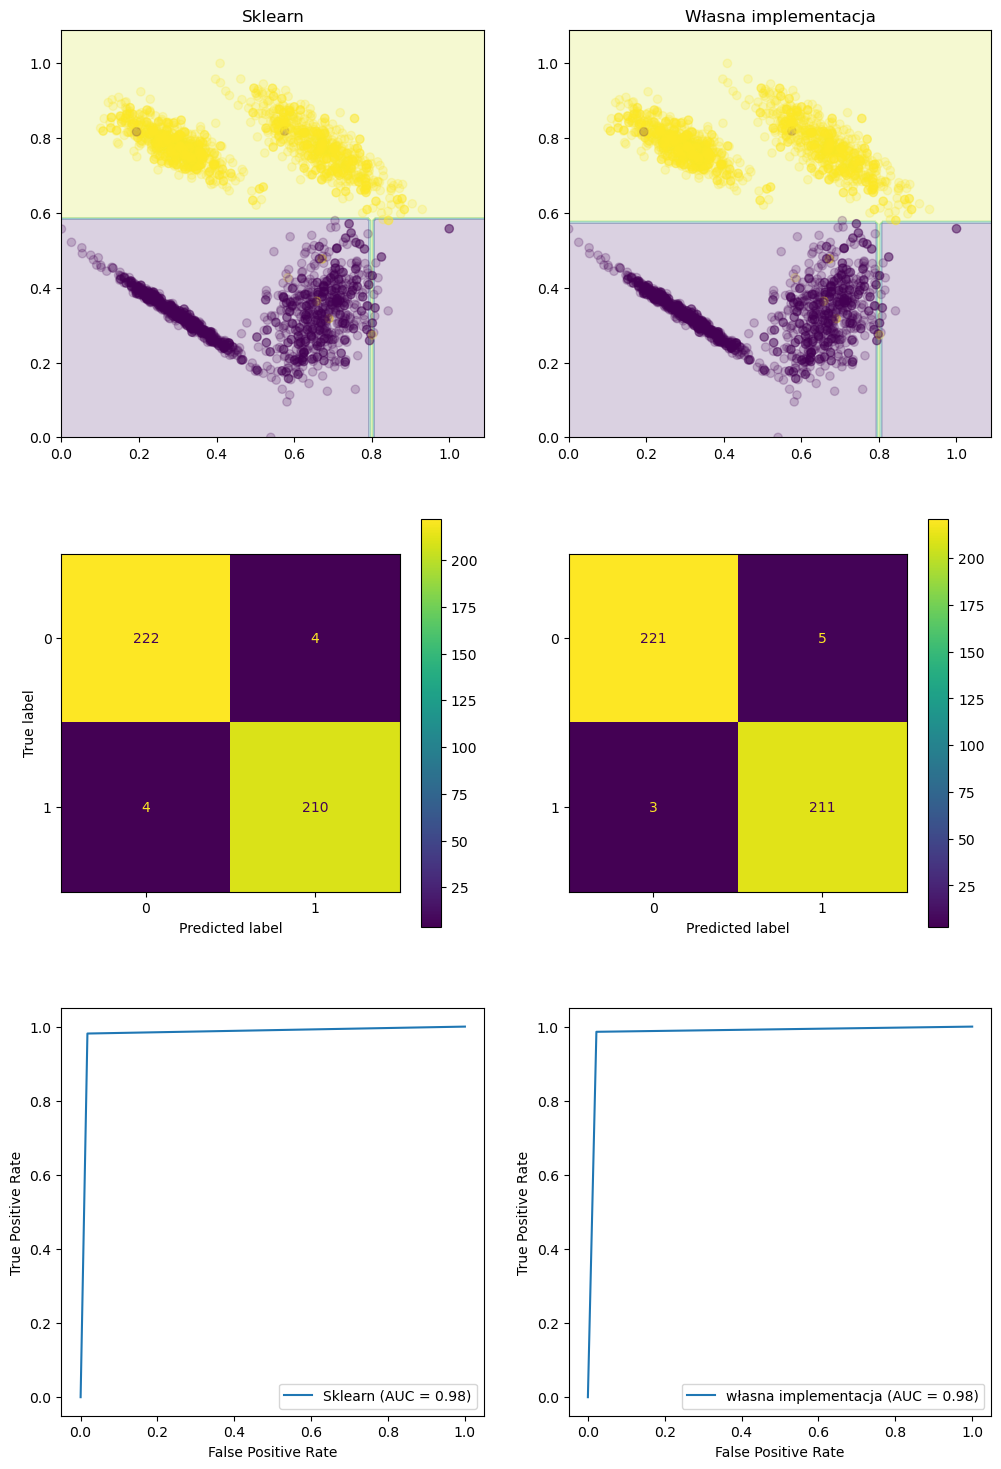

In [22]:
### 2 klastry na klasę dla maxa

X, Y = datasets.make_classification(n_samples=2200, n_features=2, random_state=222720, n_redundant=0, n_classes=2, n_clusters_per_class=2, n_informative=2, class_sep=2)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
train_X , test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=222720)

my_decision = myTree(min_samples_split=3, max_depth=5000)
sk_decision = tree.DecisionTreeClassifier()

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   0.9825|0.9867
Specyficzność |   0.4828|0.4873
Skuteczność   |   0.9886|0.9841
Czas wykonania| 1.18E-03|6.10E+00


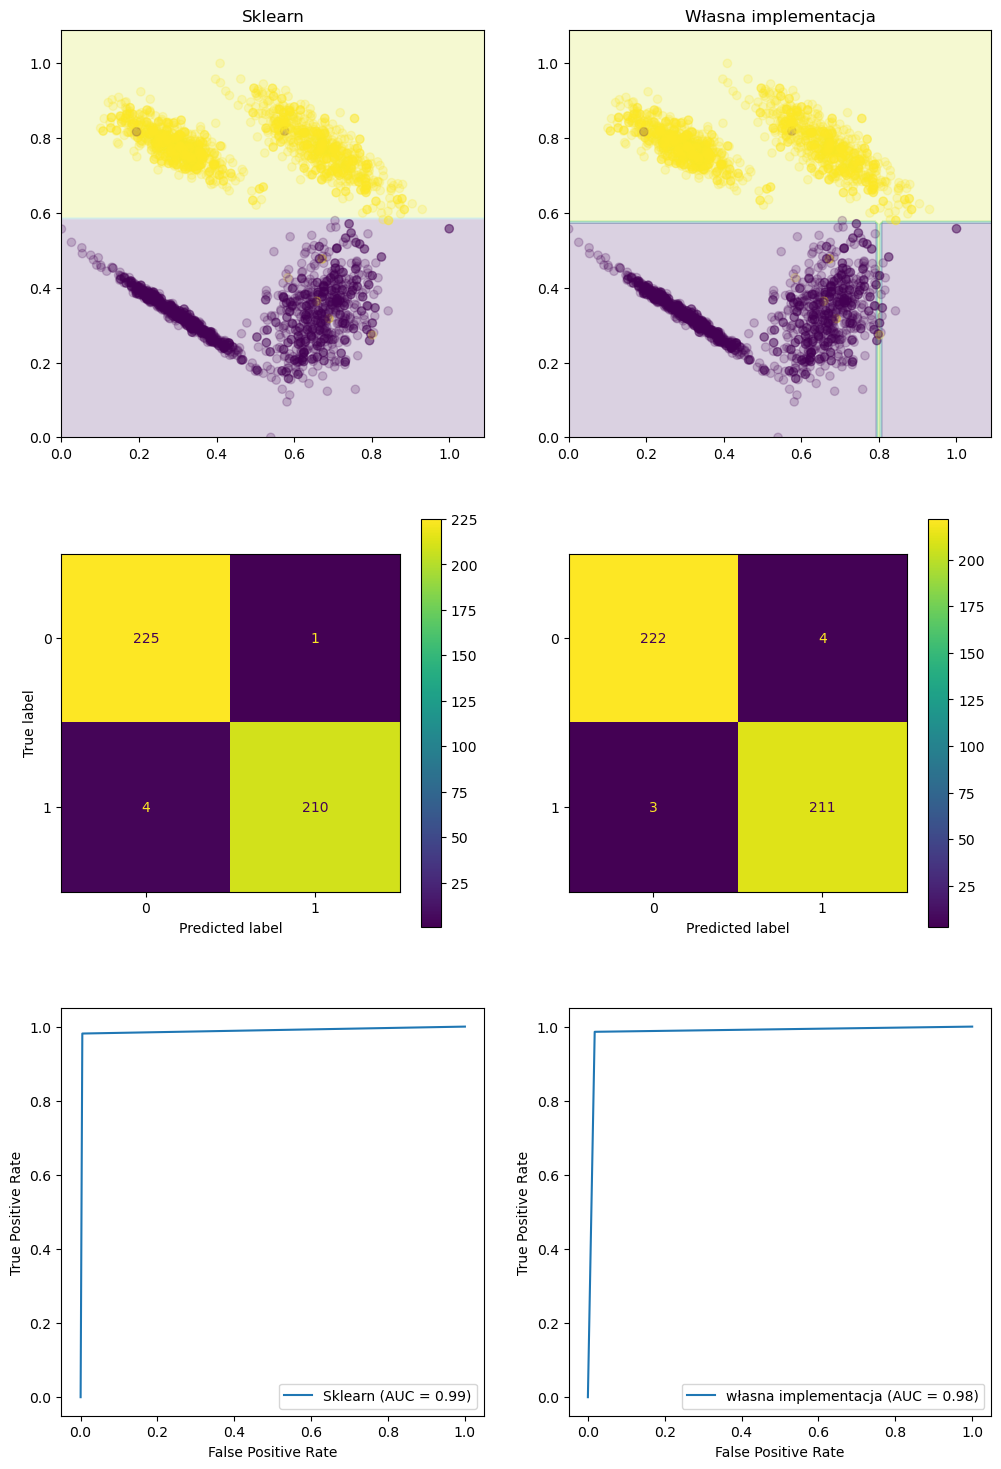

In [23]:
# Liczba klastów równa głębokości dla 2 klastrów na klasę

my_decision = myTree(min_samples_split=3, max_depth=2)
sk_decision = tree.DecisionTreeClassifier(max_depth=2)

compare_model(sk_decision, my_decision, train_X, test_X, train_Y, test_Y)

              | Sklearn | Własna
Czułość       |   1.0000|1.0000
Specyficzność |   0.5158|0.5169
Skuteczność   |   1.0000|0.9977
Czas wykonania| 1.64E-03|7.47E+00


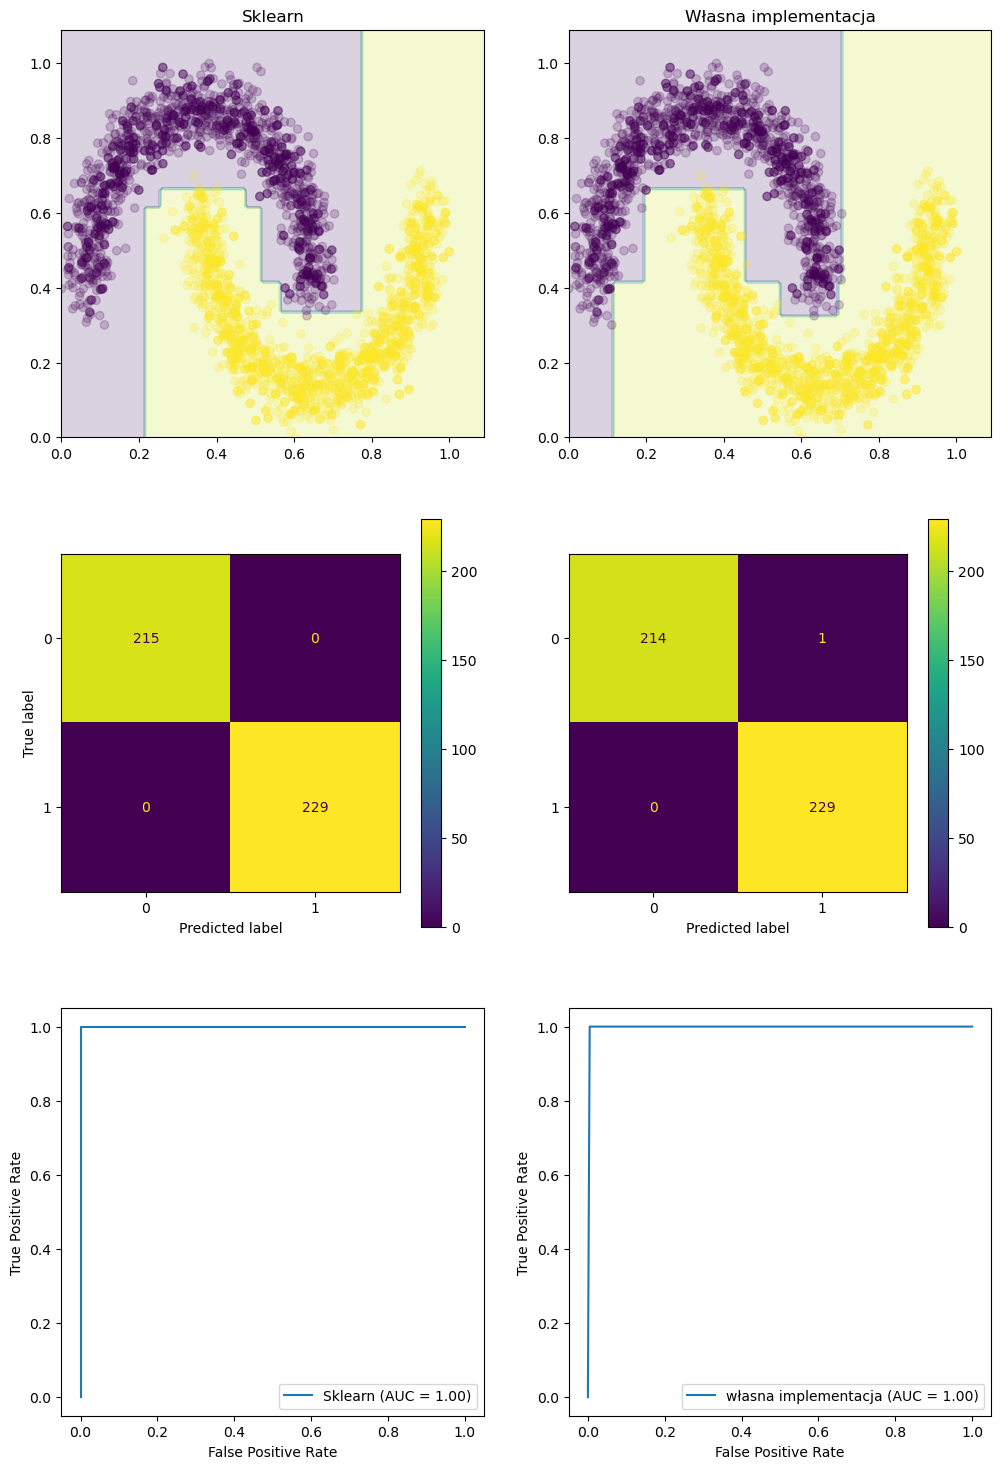

In [28]:
moons, moons_c = datasets.make_moons(n_samples=2220, noise = 0.1, random_state=222720)
moons = scaler.fit_transform(moons)
M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

my_model = myTree(min_samples_split=3, max_depth=5000)
sk_model = tree.DecisionTreeClassifier()

def compare_model(sk, my,X_tr, X_te, y_tr, y_te):
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, alpha=0.5)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, alpha=0.2)
    
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0])

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1])
    my_disp.ax_.set_ylabel('')
    
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.predict(M_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(M_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    print('              | Sklearn | Własna')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, mc_test):9.4f}|{metrics.accuracy_score(my_pred, mc_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')

compare_model(sk_model, my_model ,M_train, M_test, mc_train, mc_test)